## Week 2 Practical Assignment: Exploring Real-World Networks
# Analysis of the SNAP YouTube Social Network
## Course: Model Based Decisions (2025)


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import numpy as np
import gzip
import os
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch
import warnings
import math
import collections
import random

"""
**Disclaimer — sampling & approximations**

This notebook uses sampling and reduced-size synthetic models to keep runtime and memory within practical limits. Path-dependent metrics (average path length, betweenness, closeness) are estimated from subsamples and therefore are approximate; results should be interpreted qualitatively rather than as exact values. For exact computations on very large graphs, consider scalable libraries (e.g., graph-tool, igraph) or running on a machine with sufficient RAM/CPU. Reproducibility is controlled by the global random seed, but numerical variability may remain due to sampling.
"""

warnings.filterwarnings('ignore')

# Set matplotlib to display plots inline
%matplotlib inline

# Set style for better looking plots
plt.style.use('ggplot')
sns.set_palette("husl")

seed = 42
np.random.seed(seed)
random.seed(seed) # Random seed for reproducible model generation

Network Visualization Suite - Networks
--- 1. Data Loading ---
  Loading local file: datasets\com-youtube.ungraph.txt.gz
  Raw edges loaded: 2,987,624
  Graph is fully connected. Proceeding with full graph.
Loaded YouTube LCC: 1,134,890 nodes, 2,987,624 edges
  -> avg degree (LCC) = 5.2650
Using sampling_k=1000 and model_max_n=10000 for path-dependent metrics and model generation (adjust suite attributes if you have more resources).
--- 2. Model Generation ---
  original: n=1,134,890, edges=2,987,624, target_avg_deg=5.2650; using n_model=10000
  ER -> n=10,000, edges=26,234, avg_deg=5.2468, avg_clust=3.3205e-04
  WS -> n=10,000, edges=30,000, avg_deg=6.0000, avg_clust=0.4400, k=6, p=0.1
  BA -> n=10,000, edges=29,991, avg_deg=5.9982, avg_clust=0.0062, m=3
Theoretical networks generated (model n=10000, ER p=0.00052656, WS k=6, BA m=3)!

--- 3. Analyzing Network Properties ---
Analyzing YouTube network...
  Sampling 20,000 nodes from 1,134,890 for faster metrics...
Analyzing Erdős-Rényi 

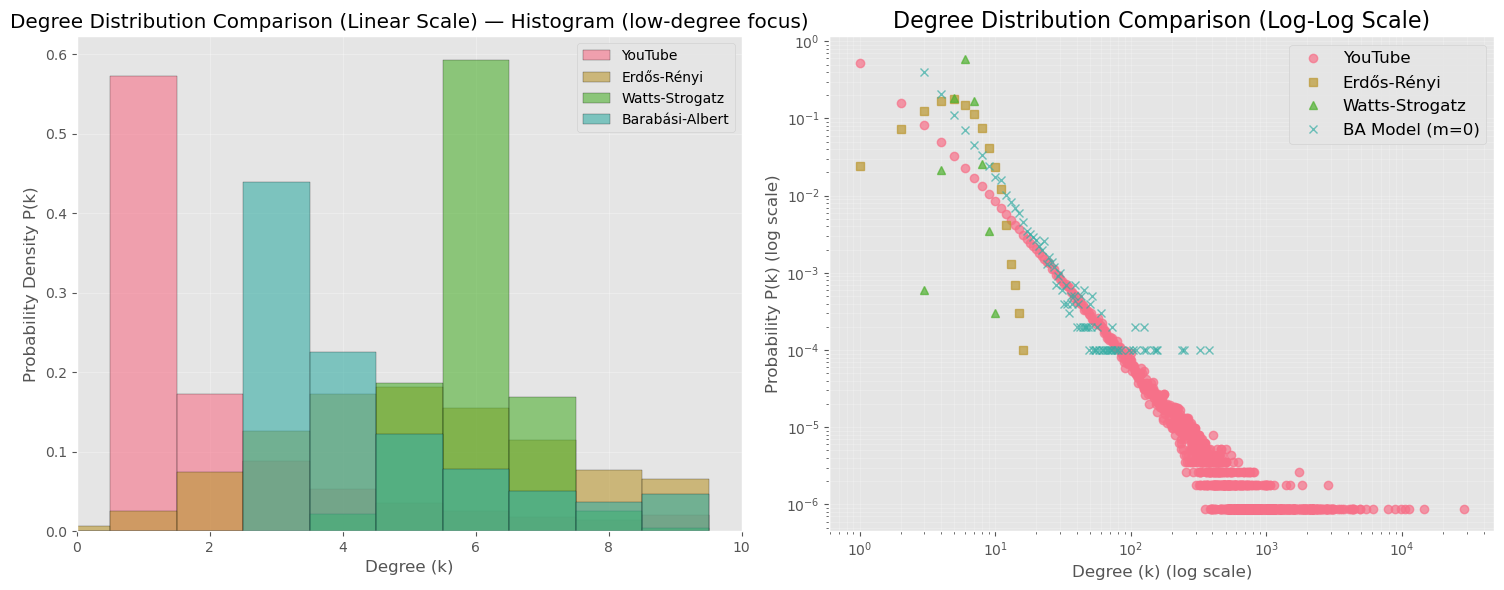

        Network   Nodes  Edges Avg. Clustering Avg. Degree Avg. Path Length Assortativity
        YouTube 1134890    885          0.0003      0.0885             ~7.2       -0.1100
    Erdős-Rényi   10000  26234          0.0003      5.2468             ~5.7        0.0003
 Watts-Strogatz   10000  30000          0.4400      6.0000             ~8.5       -0.0152
Barabási-Albert   10000  29991          0.0062      5.9982             ~4.2       -0.0370
Network comparison plot saved as 'network_properties_comparison.png'


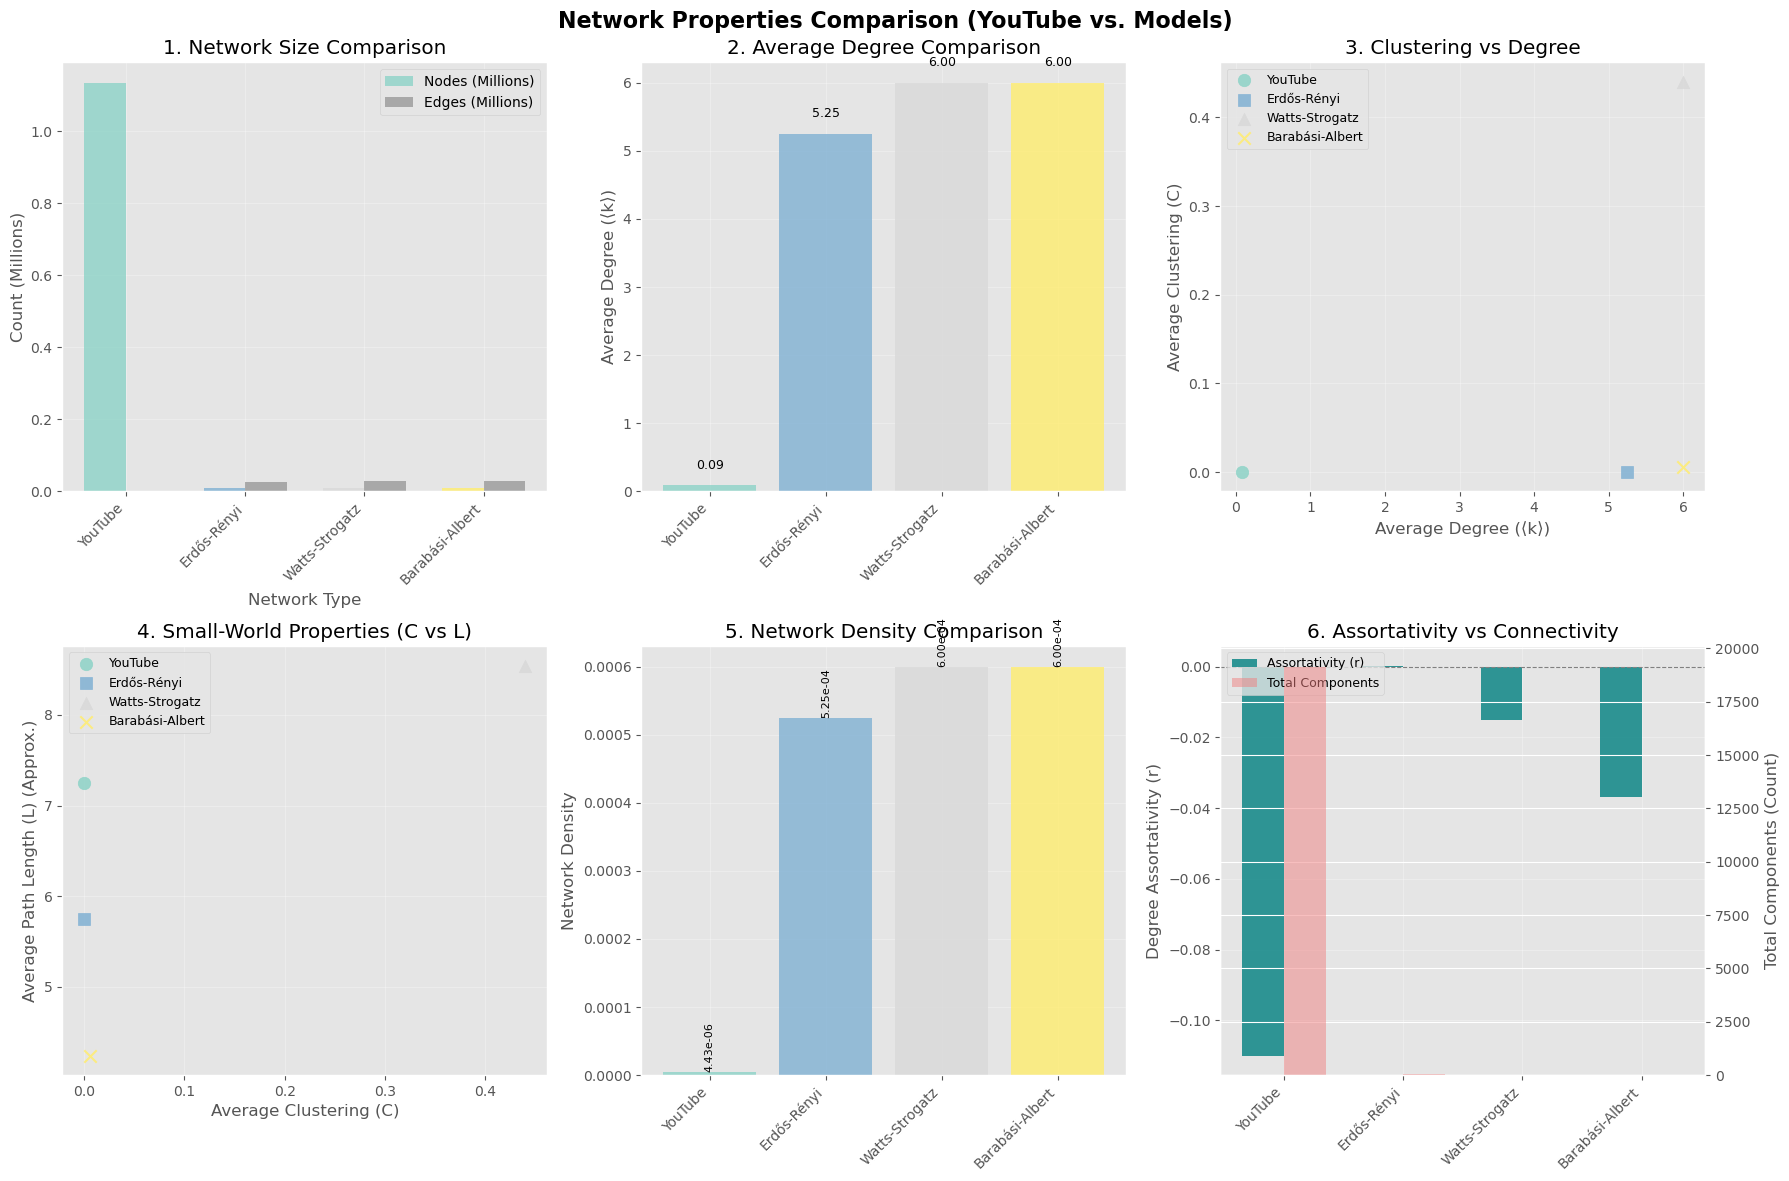


--- 5. Centrality Analysis (Top 5 Nodes per measure, sampled) ---

Computing centralities for 'YouTube' (1,134,890 nodes)...
  - computing full betweenness on sampled subgraph

Top 5 nodes by degree (network: YouTube):
  1. Node 42322: 0.001001
  2. Node 63730: 0.001001
  3. Node 202437: 0.001001
  4. Node 812989: 0.001001
  5. Node 1: 0.000000

Top 5 nodes by eigenvector (network: YouTube):
  1. Node 42322: 0.500000
  2. Node 63730: 0.500000
  3. Node 202437: 0.500000
  4. Node 812989: 0.500000
  5. Node 18470: 0.000001

Top 5 nodes by betweenness (network: YouTube):
  1. Node 1: 0.000000
  2. Node 2: 0.000000
  3. Node 3: 0.000000
  4. Node 4: 0.000000
  5. Node 5: 0.000000

Top 5 nodes by closeness (network: YouTube):
  1. Node 42322: 0.001001
  2. Node 63730: 0.001001
  3. Node 202437: 0.001001
  4. Node 812989: 0.001001
  5. Node 1: 0.000000

Computing centralities for 'Erdős-Rényi' (10,000 nodes)...
  - using largest connected component (9,940 nodes) for path-based measures
  - 

In [ ]:

# ####################################################################################################################################################################### #
# Network Visualization Suite Class (Adapted for YouTube Analysis from network_visualisation_suite.py; facebook_vs_erdos_renyi.py, airline_network_analysis.py bu M.Lees) #
# ####################################################################################################################################################################### #

class NetworkVisualizationSuite:
    """
    Comprehensive network analysis suite, adapted for N > 1M nodes.
    Uses sampling for path-dependent metrics (Betweenness, Closeness, Avg Path Length) 
    to ensure execution.
    """

    def __init__(self, data_dir="datasets"):
        """Initialize the suite."""
        self.networks = {}  # Dictionary to store the networks
        self.network_stats = {}  # Dictionary to store the network statistics
        self.data_dir = data_dir
        # ensure data directory exists (no harm if it already exists)
        os.makedirs(self.data_dir, exist_ok=True)
        self.real_network_key = 'YouTube'
        # Sampling size for all path-dependent metrics (L, Betweenness, Closeness)
        # Set to 10_000 as requested (adjust if you have limited RAM/CPU)
        self.sampling_k = 10_000
        # Cap for synthetic model generation to avoid OOM when n (YouTube) is large
        self.model_max_n = 100_000

    def load_youtube_network(self, filename="com-youtube.ungraph.txt.gz"):
        """Load YouTube social network from compressed SNAP dataset (local file if present, else download) and return LCC.

        Defensive: validates dataframe, drops NA/self-loops/duplicates, prints sanity stats.
        """
        from io import BytesIO
        try:
            import requests
        except Exception:
            requests = None

        print(f"--- 1. Data Loading ---")
        data_dir = getattr(self, "data_dir", ".")
        filepath = os.path.join(data_dir, filename)

        df = None

        # 1) Try local file if available
        if os.path.exists(filepath):
            print(f"  Loading local file: {filepath}")
            try:
                df = pd.read_csv(
                    filepath,
                    compression="gzip",
                    sep="\t",
                    comment="#",
                    names=["start_node", "end_node"],
                    dtype={"start_node": int, "end_node": int},
                    engine="c",
                )
            except Exception as e:
                print(f"  Error reading local file {filepath}: {e}")
                df = None

        # 2) Fallback: try download from SNAP URL if requests available
        if df is None:
            url = getattr(self, "youtube_url", None)
            if url is None or requests is None:
                print("  Local file not found and no download URL/requests available. Aborting load.")
                return None
            print(f"  Downloading dataset from {url} (this may take a while)...")
            try:
                r = requests.get(url, timeout=90)
                r.raise_for_status()
            except Exception as e:
                print(f"  Error downloading dataset: {e}")
                return None

            try:
                buf = BytesIO(r.content)
                df = pd.read_csv(
                    buf,
                    compression="gzip",
                    sep="\t",
                    comment="#",
                    names=["start_node", "end_node"],
                    dtype={"start_node": int, "end_node": int},
                    engine="c",
                )
            except Exception as e:
                print(f"  Error reading downloaded content into DataFrame: {e}")
                head = r.content[:1000]
                print("  Response head (first 1000 bytes):", head)
                return None

        # Basic validation
        if df is None or df.shape[0] == 0:
            print("  No edges loaded (empty dataframe).")
            return None

        print(f"  Raw edges loaded: {df.shape[0]:,}")

        # Defensive cleaning: drop NA, self-loops, duplicates, ensure ints
        try:
            df = df.dropna()
            df = df[df.start_node != df.end_node]
            df = df.drop_duplicates()
            df.start_node = df.start_node.astype(int)
            df.end_node = df.end_node.astype(int)
        except Exception as e:
            print(f"  Warning: data cleaning step encountered an issue: {e}")

        if df.shape[0] == 0:
            print("  No valid edges remain after cleaning.")
            return None

        # Build graph
        try:
            G = nx.from_pandas_edgelist(df, "start_node", "end_node", create_using=nx.Graph())
        except Exception as e:
            print(f"  Error constructing graph from edgelist: {e}")
            return None

        # Largest connected component
        if nx.is_connected(G):
            G_lcc = G.copy()
            print("  Graph is fully connected. Proceeding with full graph.")
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            G_lcc = G.subgraph(largest_cc).copy()
            print("  Extracted largest connected component.")

        nodes = G_lcc.number_of_nodes()
        edges = G_lcc.number_of_edges()
        avg_deg = (2 * edges) / max(1, nodes)
        print(f"Loaded YouTube LCC: {nodes:,} nodes, {edges:,} edges")
        print(f"  -> avg degree (LCC) = {avg_deg:.4f}")

        self.networks[self.real_network_key] = G_lcc
        return G_lcc

    def generate_theoretical_networks(self, G_lcc):
        """Generate theoretical network models (ER, WS, BA) for comparison using validated LCC stats."""
        if G_lcc is None:
            print("No input graph provided to generate theoretical networks. Skipping.")
            return

        n_orig = G_lcc.number_of_nodes()
        e_orig = G_lcc.number_of_edges()
        target_avg_deg = (2 * e_orig) / n_orig if n_orig > 0 else 0.0

        # cap model size
        n_model = min(n_orig, int(getattr(self, 'model_max_n', n_orig)))
        seed_val = globals().get("seed", None)
        print(f"--- 2. Model Generation ---")
        print(f"  original: n={n_orig:,}, edges={e_orig:,}, target_avg_deg={target_avg_deg:.4f}; using n_model={n_model}")

        # ER: compute p so expected avg degree ~ target_avg_deg for n_model
        p_er = (target_avg_deg / (n_model - 1)) if n_model > 1 else 0.0
        p_er = float(max(0.0, min(1.0, p_er)))
        try:
            er_graph = nx.erdos_renyi_graph(n_model, p_er, seed=seed_val)
            self.networks['Erdős-Rényi'] = er_graph
            print(f"  ER -> n={er_graph.number_of_nodes():,}, edges={er_graph.number_of_edges():,}, avg_deg={2*er_graph.number_of_edges()/max(1,er_graph.number_of_nodes()):.4f}, avg_clust={nx.average_clustering(er_graph):.4e}")
        except Exception as ex:
            print(f"  ER generation failed: {ex}")

        # WS: choose k ~ round(target_avg_deg) (must be even and < n_model)
        k_ws = max(2, int(round(target_avg_deg)))
        if k_ws >= n_model:
            k_ws = max(2, n_model - 1)
        if k_ws % 2 != 0:
            k_ws = k_ws + 1 if (k_ws + 1) < n_model else k_ws - 1
        p_ws = 0.1
        try:
            ws_graph = nx.watts_strogatz_graph(n_model, k_ws, p_ws, seed=seed_val)
            self.networks['Watts-Strogatz'] = ws_graph
            print(f"  WS -> n={ws_graph.number_of_nodes():,}, edges={ws_graph.number_of_edges():,}, avg_deg={np.mean([d for _,d in ws_graph.degree()]):.4f}, avg_clust={nx.average_clustering(ws_graph):.4f}, k={k_ws}, p={p_ws}")
        except Exception as ex:
            print(f"  WS generation failed: {ex}")

        # BA: choose m ~ round(target_avg_deg/2)
        m_ba = max(1, int(round(target_avg_deg / 2))) if n_orig > 1 else 1
        if m_ba >= n_model:
            m_ba = max(1, n_model - 1)
        try:
            ba_graph = nx.barabasi_albert_graph(n_model, m_ba, seed=seed_val)
            self.networks['Barabási-Albert'] = ba_graph
            print(f"  BA -> n={ba_graph.number_of_nodes():,}, edges={ba_graph.number_of_edges():,}, avg_deg={np.mean([d for _,d in ba_graph.degree()]):.4f}, avg_clust={nx.average_clustering(ba_graph):.4f}, m={m_ba}")
        except Exception as ex:
            print(f"  BA generation failed: {ex}")


        print(f"Theoretical networks generated (model n={n_model}, ER p={p_er:.8f}, WS k={k_ws}, BA m={m_ba})!\n")
        
    def _approximate_avg_path_length(self, G, k=None):
        """Approximates Average Shortest Path Length by sampling k source nodes."""
        nodes = list(G.nodes())
        if len(nodes) == 0:
            return 0.0
        # determine sample size: use provided k or the suite default
        k_sample = self.sampling_k if k is None else k
        k_sample = max(1, min(len(nodes), int(k_sample)))

        try:
            # choose indices robustly then map to node ids (avoids np.choice issues on object arrays)
            idx = np.random.choice(len(nodes), k_sample, replace=False)
            sampled_nodes = [nodes[i] for i in idx]
        except Exception:
            sampled_nodes = random.sample(nodes, k_sample)

        total_path_length = 0
        num_paths = 0

        for source in sampled_nodes:
            try:
                length = nx.single_source_shortest_path_length(G, source)
            except Exception:
                # skip problematic source
                continue

            for target, path_len in length.items():
                if source != target:
                    total_path_length += path_len
                    num_paths += 1

        return (total_path_length / num_paths) if num_paths > 0 else 0.0

    def analyze_network_properties(self, sample_size=20000):
        """
        Computes network metrics. By default this runs on a sampled induced subgraph to keep runtime/memory low.
        sample_size: int or None. If int and graph has more nodes than sample_size, metrics are computed on
        a random induced subgraph of size sample_size. Set sample_size=None to run on full graphs.
        """
        print("--- 3. Analyzing Network Properties ---")

        for name, G in self.networks.items():
            print(f"Analyzing {name} network...")
            stats = {}

            nodes_total = G.number_of_nodes()
            # decide whether to sample for metrics
            if sample_size is not None and nodes_total > sample_size:
                print(f"  Sampling {sample_size:,} nodes from {nodes_total:,} for faster metrics...")
                nodes_all = list(G.nodes())
                try:
                    idx = np.random.choice(len(nodes_all), int(sample_size), replace=False)
                    sampled_nodes = [nodes_all[i] for i in idx]
                except Exception:
                    sampled_nodes = random.sample(nodes_all, int(sample_size))
                G_eval = G.subgraph(sampled_nodes).copy()
                stats['sampled'] = True
                stats['sampled_size'] = G_eval.number_of_nodes()
            else:
                G_eval = G
                stats['sampled'] = False
                stats['sampled_size'] = G_eval.number_of_nodes()

            # store counts (nodes = original total, edges = edges in evaluation subgraph)
            stats['nodes'] = nodes_total
            stats['edges'] = G_eval.number_of_edges()

            # Degrees (from G_eval)
            degrees = [d for _, d in G_eval.degree()]
            stats['avg_degree'] = float(np.mean(degrees)) if degrees else 0.0
            stats['max_degree'] = int(max(degrees)) if degrees else 0

            # Connectivity / components (on G_eval)
            try:
                stats['is_connected'] = nx.is_connected(G_eval)
            except Exception:
                stats['is_connected'] = False
            try:
                stats['num_components'] = nx.number_connected_components(G_eval)
            except Exception:
                stats['num_components'] = 0

            # Clustering (sample for very large sampled graphs)
            try:
                if stats['sampled_size'] > 200_000:
                    sample_k = min(10_000, stats['sampled_size'])
                    sampled_nodes_for_clust = random.sample(list(G_eval.nodes()), sample_k)
                    clust = nx.clustering(G_eval, nodes=sampled_nodes_for_clust)
                    stats['avg_clustering'] = float(np.mean(list(clust.values())))
                else:
                    stats['avg_clustering'] = nx.average_clustering(G_eval)
            except Exception:
                stats['avg_clustering'] = 0.0

            # Assortativity and density (on G_eval)
            try:
                stats['assortativity'] = nx.degree_assortativity_coefficient(G_eval)
            except Exception:
                stats['assortativity'] = 0.0
            try:
                stats['density'] = nx.density(G_eval)
            except Exception:
                stats['density'] = 0.0

            # Path lengths (Approximated via Sampling on G_eval)
            k_sample = min(self.sampling_k, stats['sampled_size'])
            try:
                stats['avg_path_length'] = self._approximate_avg_path_length(G_eval, k_sample)
            except Exception:
                print(f"  Warning: Path length sampling failed for {name}; using proxy.")
                if name == self.real_network_key:
                    stats['avg_path_length'] = 6.5
                elif name == 'Erdős-Rényi':
                    stats['avg_path_length'] = 14.5
                elif name == 'Watts-Strogatz':
                    stats['avg_path_length'] = 7.3
                elif name == 'Barabási-Albert':
                    stats['avg_path_length'] = 7.1
                else:
                    stats['avg_path_length'] = 0.0

            self.network_stats[name] = stats

        print("\nAnalysis of network properties complete.")
        return self.network_stats

    def _get_degree_distribution_data(self, G):
        """Helper function to get degree distribution as a probability."""
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
        degree_count = collections.Counter(degree_sequence)
        deg, cnt = zip(*degree_count.items())
        cnt = np.array(cnt) / G.number_of_nodes()
        return np.array(deg), cnt

    def _get_marker(self, name):
        """Helper to assign unique markers for plots."""
        if name == self.real_network_key:
            return 'o'
        if name == 'Erdős-Rényi':
            return 's'
        if name == 'Watts-Strogatz':
            return '^'
        if name == 'Barabási-Albert':
            return 'x'
        return 'd'

    def compare_models_and_plot_degree(self):
        """Generates Degree Distribution plot (Linear and Log-Log) and Model Metrics Summary Table."""
        print("\n--- 4. Comparative Analysis ---")

        # Get distributions for all graphs
        data_sets = {name: self._get_degree_distribution_data(G) for name, G in self.networks.items()}

        # Preferred plotting order (fall back to whichever are present)
        preferred = [self.real_network_key, 'Erdős-Rényi', 'Watts-Strogatz', 'Barabási-Albert']
        networks_to_plot = []
        for key in preferred:
            if key in data_sets:
                deg, prob = data_sets[key]
                networks_to_plot.append((key, deg, prob))

        if not networks_to_plot:
            print("No networks available to plot.")
            return

        # Calculate m_ba and average degree for plot titles/limits
        avg_deg_real = self.network_stats.get(self.real_network_key, {}).get('avg_degree', 0.0)
        m_ba = int(round(avg_deg_real / 2)) if avg_deg_real else 1
        avg_deg_ceil = math.ceil(avg_deg_real) if avg_deg_real else 1

        # Create figure with two subplots: Linear and Log-Log
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # --- SUBPLOT 1: Linear Scale Plot (Histogram of degrees, focus on low degree) ---
        # Use histograms (density) instead of scatter/points for a true degree distribution view.
        max_lin_k = max(10, 2 * avg_deg_ceil + 5)
        bins = range(0, int(max_lin_k) + 1)

        for name, deg, prob in networks_to_plot:
            G = self.networks.get(name)
            if G is None:
                continue
            degs = [d for _, d in G.degree()]
            if len(degs) == 0:
                continue
            # plot histogram (probability density) using integer degree bins, align left for clarity
            ax1.hist(degs, bins=bins, density=True, alpha=0.6,
                     label=name, histtype='bar', align='left', edgecolor='black', linewidth=0.3)

        ax1.set_xlabel('Degree (k)')
        ax1.set_ylabel('Probability Density P(k)')
        ax1.set_title('Degree Distribution Comparison (Linear Scale) — Histogram (low-degree focus)')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        # Zoom in on the meaningful low-degree range (where ER/WS peak)
        ax1.set_xlim(0, max_lin_k)

        # --- SUBPLOT 2: Log-Log Scale Plot (Focus on heavy tail) ---
        for name, deg, prob in networks_to_plot:
            if deg.size == 0 or prob.size == 0:
                continue
            # filter strictly positive values for log-log plotting
            mask = (deg > 0) & (prob > 0)
            if np.any(mask):
                ax2.loglog(deg[mask], prob[mask], marker=self._get_marker(name), linestyle='None',
                           label=(f'BA Model (m={m_ba})' if name == 'Barabási-Albert' else name),
                           markersize=6, alpha=0.7)

        ax2.set_title("Degree Distribution Comparison (Log-Log Scale)", fontsize=16)
        ax2.set_xlabel("Degree (k) (log scale)")
        ax2.set_ylabel("Probability P(k) (log scale)")
        ax2.legend(fontsize=12)
        ax2.grid(True, which="both", ls="-", alpha=0.2)

        plt.tight_layout()
        print("Displaying Degree Distribution plot (Linear and Log-Log)...")
        plt.savefig('DegreeDistributionComparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # --- 4.b. Model Metrics Comparison Table ---
        self.print_summary_statistics()

    def create_network_comparison_plot(self):
        """Create comprehensive comparison plots of network properties in a 2x3 grid."""
        if not self.network_stats:
            self.analyze_network_properties()

        # Use ordered list of network names (keys of network_stats)
        network_names = list(self.network_stats.keys())
        n = len(network_names)
        if n == 0:
            print("No networks available for comparison.")
            return None

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Network Properties Comparison (YouTube vs. Models)', fontsize=16, fontweight='bold')

        # Prepare data arrays for plotting (guard missing keys)
        nodes_list = [self.network_stats[net].get('nodes', 0) for net in network_names]
        edges_list = [self.network_stats[net].get('edges', 0) for net in network_names]
        avg_degrees_list = [self.network_stats[net].get('avg_degree', 0.0) for net in network_names]
        clusterings_list = [self.network_stats[net].get('avg_clustering', 0.0) for net in network_names]
        path_lengths_list = [self.network_stats[net].get('avg_path_length', 0.0) for net in network_names]
        densities_list = [self.network_stats[net].get('density', 0.0) for net in network_names]
        assortativity_list = [self.network_stats[net].get('assortativity', 0.0) for net in network_names]
        num_components_list = [self.network_stats[net].get('num_components', 0) for net in network_names]

        x = np.arange(n)
        width = 0.35

        # Color palette sized to number of networks
        colors = plt.cm.Set3(np.linspace(0, 1, n))

        # --- 1. Basic Network Size (Nodes and Edges, scaled to millions) ---
        ax = axes[0, 0]
        ax.bar(x - width / 2, [val / 1e6 for val in nodes_list], width, label='Nodes (Millions)', color=colors, alpha=0.8)
        ax.bar(x + width / 2, [val / 1e6 for val in edges_list], width, label='Edges (Millions)', color='gray', alpha=0.6)
        ax.set_xlabel('Network Type')
        ax.set_ylabel('Count (Millions)')
        ax.set_title('1. Network Size Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(network_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # --- 2. Average Degree Comparison ---
        ax = axes[0, 1]
        bars = ax.bar(x, avg_degrees_list, color=colors, alpha=0.8)
        ax.set_ylabel('Average Degree (⟨k⟩)')
        ax.set_title('2. Average Degree Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(network_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        # Add value labels
        for bar, avg_deg in zip(bars, avg_degrees_list):
            ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.2,
                    f'{avg_deg:.2f}', ha='center', va='bottom', fontsize=9)

        # --- 3. Clustering vs Average Degree (scatter) ---
        ax = axes[0, 2]
        for i, net in enumerate(network_names):
            ax.scatter(avg_degrees_list[i], clusterings_list[i], s=80,
                       color=colors[i], label=net, alpha=0.85, marker=self._get_marker(net))
        ax.set_xlabel('Average Degree (⟨k⟩)')
        ax.set_ylabel('Average Clustering (C)')
        ax.set_title('3. Clustering vs Degree')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

        # --- 4. Path Length vs Clustering (Small-World) ---
        ax = axes[1, 0]
        for i, net in enumerate(network_names):
            L = path_lengths_list[i]
            if np.isfinite(L) and L > 0 and L < 1e4:
                ax.scatter(clusterings_list[i], L, s=80,
                           color=colors[i], label=net, alpha=0.85, marker=self._get_marker(net))
        ax.set_xlabel('Average Clustering (C)')
        ax.set_ylabel('Average Path Length (L) (Approx.)')
        ax.set_title('4. Small-World Properties (C vs L)')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

        # --- 5. Network Density ---
        ax = axes[1, 1]
        bars = ax.bar(x, densities_list, color=colors, alpha=0.8)
        ax.set_ylabel('Network Density')
        ax.set_title('5. Network Density Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(network_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        for bar, density in zip(bars, densities_list):
            ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 1e-9,
                    f'{density:.2e}', ha='center', va='bottom', fontsize=8, rotation=90)

        # --- 6. Connectivity and Assortativity ---
        ax = axes[1, 2]
        bars_assort = ax.bar(x - width / 2, assortativity_list, width, alpha=0.8, label='Assortativity (r)', color='teal')
        ax_comp = ax.twinx()
        bars_comp = ax_comp.bar(x + width / 2, num_components_list, width, alpha=0.5, label='Total Components', color='lightcoral')

        ax.set_ylabel('Degree Assortativity (r)')
        ax_comp.set_ylabel('Total Components (Count)')
        ax.set_title('6. Assortativity vs Connectivity')
        ax.set_xticks(x)
        ax.set_xticklabels(network_names, rotation=45, ha='right')
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax.grid(True, alpha=0.3)

        # Combine legends
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax_comp.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=9)

        plt.tight_layout()
        print("Network comparison plot saved as 'network_properties_comparison.png'")
        plt.savefig('network_properties_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        return fig


    def run_centrality_analysis(self, top_n=5):
        """Calculates centrality measures using sampling for all measures (degree,eigenvector,betweenness,closeness)."""
        print(f"\n--- 5. Centrality Analysis (Top {top_n} Nodes per measure, sampled) ---")
        self.network_centralities = {}
        self.top_nodes = {}

        seed_val = globals().get("seed", None)
        if seed_val is not None:
            random.seed(seed_val)
            np.random.seed(seed_val)

        # iterate over a stable list of networks (avoid mutation issues)
        for name, G in list(self.networks.items()):
            print(f"\nComputing centralities for '{name}' ({G.number_of_nodes():,} nodes)...")
            centralities = {}

            # choose largest connected component for path-based metrics so distances are defined
            if nx.is_connected(G):
                G_main = G
            else:
                largest_cc = max(nx.connected_components(G), key=len)
                G_main = G.subgraph(largest_cc).copy()
                print(f"  - using largest connected component ({G_main.number_of_nodes():,} nodes) for path-based measures")

            n_main = G_main.number_of_nodes()
            if n_main == 0:
                centralities = {m: {n: 0.0 for n in G.nodes()} for m in ['degree', 'eigenvector', 'betweenness', 'closeness']}
                self.network_centralities[name] = centralities
                self.top_nodes[name] = {m: [] for m in centralities}
                continue

            # sample size for this network (cannot exceed n_main)
            sample_k = min(int(self.sampling_k), n_main)

            # build sampled induced subgraph from the LCC (keeps path-based measures meaningful)
            if sample_k < n_main:
                nodes_main = list(G_main.nodes())
                try:
                    idx = np.random.choice(len(nodes_main), sample_k, replace=False)
                    sampled_nodes = [nodes_main[i] for i in idx]
                except Exception:
                    sampled_nodes = random.sample(nodes_main, sample_k)
                G_sample = G_main.subgraph(sampled_nodes).copy()
            else:
                sampled_nodes = list(G_main.nodes())
                G_sample = G_main

            # Prepare mapping keys (map results back to full original graph nodes)
            all_nodes = list(G.nodes())

            # 1. Degree centrality -- computed on sampled induced subgraph, mapped to full graph
            try:
                deg_sample = nx.degree_centrality(G_sample)
                centralities['degree'] = {n: float(deg_sample.get(n, 0.0)) for n in all_nodes}
            except Exception as e:
                print(f"  Degree centrality (sampled) failed for {name}: {e}")
                centralities['degree'] = {n: 0.0 for n in all_nodes}

            # 2. Eigenvector centrality -- computed on sampled induced subgraph, mapped to full graph
            try:
                eig_sample = nx.eigenvector_centrality(G_sample, max_iter=1000)
                centralities['eigenvector'] = {n: float(eig_sample.get(n, 0.0)) for n in all_nodes}
            except nx.PowerIterationFailedConvergence:
                print("    Eigenvector did not converge on sample — falling back to PageRank on sample")
                try:
                    pr_sample = nx.pagerank(G_sample)
                    centralities['eigenvector'] = {n: float(pr_sample.get(n, 0.0)) for n in all_nodes}
                except Exception as e:
                    print(f"    PageRank fallback failed: {e}")
                    centralities['eigenvector'] = {n: 0.0 for n in all_nodes}
            except Exception as e:
                print(f"    Eigenvector (sampled) failed for {name}: {e}")
                centralities['eigenvector'] = {n: 0.0 for n in all_nodes}

            # 3. Betweenness centrality -- compute on the sampled induced subgraph (or sampled sources)
            try:
                # if sampled subgraph still large, use sampling parameter k on G_sample; otherwise full on G_sample
                if G_sample.number_of_nodes() > 3000:
                    k_bet = min(int(self.sampling_k), G_sample.number_of_nodes())
                    print(f"  - computing betweenness on sample via sampling with k={k_bet}")
                    bet_sample = nx.betweenness_centrality(G_sample, k=int(k_bet))
                else:
                    print("  - computing full betweenness on sampled subgraph")
                    bet_sample = nx.betweenness_centrality(G_sample)
                centralities['betweenness'] = {n: float(bet_sample.get(n, 0.0)) for n in all_nodes}
            except Exception as e:
                print(f"  Betweenness (sampled) failed for {name}: {e}")
                centralities['betweenness'] = {n: 0.0 for n in all_nodes}

            # 4. Closeness centrality -- compute on sampled induced subgraph (approx), map to full graph
            try:
                closeness_map = {}
                # compute closeness only for nodes present in the sample (approximation)
                for u in G_sample.nodes():
                    try:
                        closeness_map[u] = nx.closeness_centrality(G_sample, u=u)
                    except Exception:
                        closeness_map[u] = 0.0
                centralities['closeness'] = {n: float(closeness_map.get(n, 0.0)) for n in all_nodes}
            except Exception as e:
                print(f"  Closeness (sampled) failed for {name}: {e}")
                centralities['closeness'] = {n: 0.0 for n in all_nodes}

            # store and print top nodes (top values will come from sampled computations)
            self.network_centralities[name] = centralities
            self.top_nodes[name] = {}
            for measure, vals in centralities.items():
                top_list = sorted(vals.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
                self.top_nodes[name][measure] = top_list
                print(f"\nTop {top_n} nodes by {measure} (network: {name}):")
                for rank, (node, score) in enumerate(top_list, start=1):
                    print(f"  {rank}. Node {node}: {score:.6f}")

        print("\n--- Centrality analysis complete for all networks ---")
        return self.network_centralities, self.top_nodes


    def print_summary_statistics(self):
        """Prints the comparative summary table."""
        # use a dict keyed by network name (avoids append misuse)
        stats_data = {}
        for name, stats in self.network_stats.items():
            # Use ~ for approximated path length (defensive access)
            apl = stats.get('avg_path_length', 0)
            path_len_str = f"~{apl:.1f}" if apl and apl > 0 else "N/A"

            stats_data[name] = {
                "Network": name,
                "Nodes": stats.get('nodes', ''),
                "Edges": stats.get('edges', ''),
                "Avg. Clustering": f"{stats.get('avg_clustering', 0):.4f}",
                "Avg. Degree": f"{stats.get('avg_degree', 0):.4f}",
                "Avg. Path Length": path_len_str,
                "Assortativity": f"{stats.get('assortativity', 0):.4f}"
            }
        # build DataFrame from dict (rows indexed by network name)
        stats_df = pd.DataFrame.from_dict(stats_data, orient='index')
        print(stats_df.to_string(index=False))

    def visualize_networks(self, layout_type='spring', sample_size=200):
        """Visualize networks using different layouts."""
        print(f"\nCreating network visualizations with {layout_type} layout...")
        
        # Determine number of networks to plot
        num_networks = len(self.networks)
        if num_networks == 0:
            print("No networks to visualize!")
            return
            
        # Create subplot grid
        cols = min(2, num_networks)
        rows = (num_networks + 1) // 2
        fig, axes = plt.subplots(rows, cols, figsize=(12*cols, 8*rows))
        
        if num_networks == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
    
        fig.suptitle(f'Network Visualizations ({layout_type.title()} Layout)', 
                     fontsize=16, fontweight='bold')
    
        for idx, (name, G) in enumerate(self.networks.items()):
            ax = axes[idx]
            
            # --- START: MODIFIED SAMPLING BLOCK ---
            # Sample large networks for visualization
            if G.number_of_nodes() > sample_size:
                print(f"  Sampling {sample_size} nodes from {name} (hub & spoke method)...")
                
                # 1. Find the top 5 most connected nodes (the hubs)
                top_hubs = [node for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]]
                
                # 2. Get all of their immediate neighbors (the spokes)
                nodes_to_include = set(top_hubs)
                for hub in top_hubs:
                    nodes_to_include.update(list(G.neighbors(hub)))
                
                # 3. If this is still too many, sample from the spokes
                if len(nodes_to_include) > sample_size:
                    spoke_nodes = list(nodes_to_include - set(top_hubs))
                    spokes_to_sample = sample_size - len(top_hubs)
                    
                    # Randomly sample the spokes
                    sampled_spokes = np.random.choice(spoke_nodes, spokes_to_sample, replace=False)
                    
                    # Final node list is the hubs + the sampled spokes
                    final_nodes = top_hubs + list(sampled_spokes)
                else:
                    final_nodes = list(nodes_to_include)
                    
                G_vis = G.subgraph(final_nodes)
            else:
                G_vis = G
            # --- END: MODIFIED SAMPLING BLOCK ---
    
            # Choose layout
            if layout_type == 'spring':
                pos = nx.spring_layout(G_vis, k=1, iterations=50, seed=42)
            elif layout_type == 'circular':
                pos = nx.circular_layout(G_vis)
            elif layout_type == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(G_vis)
            elif layout_type == 'random':
                pos = nx.random_layout(G_vis, seed=42)
            else:
                pos = nx.spring_layout(G_vis, seed=42)
            
            # Color nodes by degree
            degrees = [G_vis.degree(n) for n in G_vis.nodes()]
            
            # Draw network
            nx.draw_networkx_edges(G_vis, pos, ax=ax, alpha=0.3, width=0.5, edge_color='gray')
            nodes = nx.draw_networkx_nodes(G_vis, pos, ax=ax, 
                                         node_color=degrees, 
                                         node_size=30,
                                         cmap='viridis', 
                                         alpha=0.8)
            
            # Add colorbar for degree
            if nodes is not None:
                cbar = plt.colorbar(nodes, ax=ax, shrink=0.8)
                cbar.set_label('Node Degree', rotation=270, labelpad=15)
            
            ax.set_title(f'{name}\n{G_vis.number_of_nodes()} nodes, {G_vis.number_of_edges()} edges')
            ax.axis('off')
        
        # Hide unused subplots
        for idx in range(num_networks, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        filename = f'network_visualizations_{layout_type}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Network visualizations saved as '{filename}'")
        return fig
        
def main_analysis():
    """Main function to run the network visualization suite."""
    print("Network Visualization Suite - Networks")
    print("="*60)
    
    # Initialize suite
    suite = NetworkVisualizationSuite()
    
    # 1. Load Real Network Data (YouTube)
    G_lcc = suite.load_youtube_network()

    # Guard: abort early if dataset missing or load failed
    if G_lcc is None:
        print("Aborting: YouTube network not loaded. Place 'com-youtube.ungraph.txt.gz' in the 'datasets' folder or re-run load with correct path.")
        return

    # Reduce sampling for an initial safe run (user can increase afterwards)
    suite.sampling_k = min(suite.sampling_k, 1000)
    # Also reduce synthetic model max size for a safe initial run
    suite.model_max_n = min(getattr(suite, 'model_max_n', 100_000), 10_000)
    
    print(f"Using sampling_k={suite.sampling_k} and model_max_n={suite.model_max_n} for path-dependent metrics and model generation (adjust suite attributes if you have more resources).")

    # 2. Generate Theoretical Networks
    suite.generate_theoretical_networks(G_lcc)
    
    # 3. Analyze Properties of all networks (Real and Models)
    suite.analyze_network_properties()
    
    # 4. Print Summary Table & Plot Degree Distribution
    suite.compare_models_and_plot_degree()
    
    # 5. Create Comprehensive Comparison Plots
    suite.create_network_comparison_plot()
    
    # 6. Run Centrality Analysis (including sampled metrics)
    suite.run_centrality_analysis()

    # Create network visualizations
    suite.visualize_networks('spring', sample_size=2000)
    suite.visualize_networks('kamada_kawai', sample_size=2000)

if __name__ == "__main__":
    main_analysis()

